<a href="https://colab.research.google.com/github/bungagana/MODELING---KLASIFIKASI--LABEL---KODEIN/blob/main/TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re

## Preprocessing

In [ ]:
df1 = pd.read_excel('deals_update.xlsx')
df2 = pd.read_excel('Activities.xlsx')

In [ ]:
df2['Date'] = pd.to_datetime(df2['Date'])

# Memilih activity terakhir di tiap deal (jika deal memiliki > 1 activity)
df2 = df2.sort_values('Date').groupby('Deals').tail(1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 56 to 3
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   No                              38 non-null     int64         
 1   Title                           38 non-null     object        
 2   Type Activity                   38 non-null     object        
 3   Date                            38 non-null     datetime64[ns]
 4   Reminder 
(Minutes before Due)  37 non-null     float64       
 5   Owner                           38 non-null     object        
 6   Note                            38 non-null     object        
 7   Deals                           38 non-null     object        
 8   Contacts                        38 non-null     object        
 9   Companies                       37 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 3.3+ KB


In [ ]:
# Menggabungkan data deals dengan activity nya dengan key deal
merged_df = pd.merge(df1, df2, left_on='Deal Name', right_on='Deals', how='left')
merged_df.tail()

,No_x,Deal Name,Stage,Label,Reason,Amount,Expected Closed Date,Tags,Owner_x,Companies_x,...,No_y,Title,Type Activity,Date,Reminder \n(Minutes before Due),Owner_y,Note,Deals,Contacts_y,Companies_y
76,77,Sales Training (Volvo Cars),INITIAL MEETING/CALL,COLD,Tidak cocok dengan Custom Development/tidak di...,-,2024-01-01,NO TAG,KRM,Volvo Cars,...,60.0,First Meeting menggali kebutuhan,TASK,2023-09-22 14:00:00,30.0,Krismanto,MoM Kris dengan Pak Toto_Volvo Cars Indonesia....,Sales Training (Volvo Cars),-,-
77,78,Pembuatan Logo - ERA JAYA,INITIAL MEETING/CALL,NaN,NaN,"Rp12.500.000,00",2024-06-30,NO TAG,DEL,ERA JAYA,...,4.0,update follow up,TASK,2024-06-29 14:00:00,30.0,Delton,"Sudah kirim quotation , sedang di review",Pembuatan Logo - ERA JAYA,-,-
78,79,Software Seni (Bu Nina) - Website E Commerce,NEGOTIATION,LOST,"Cancel Project, dikerjakan internal","Rp150.000.000,00",2024-06-30,NO TAG,DEL,NaN,...,10.0,update follow up,TASK,2024-06-21 09:00:00,30.0,Delton,"Sudah meeting dengan tim , kebutuhan website d...",Software Seni (Bu Nina) - Website E Commerce,Bu Nin,-
79,80,Bunda BC - Optimisasi Ads di Marketplace,INITIAL MEETING/CALL,NaN,NaN,NaN,2024-06-30,NO TAG,DEL,Bunda BC,...,25.0,update follow up,TASK,2024-06-07 17:00:00,30.0,Delton,Mau meeting di tanggal 08 Juni 2024 sama mas G...,Bunda BC - Optimisasi Ads di Marketplace,-,-
80,81,Bank Hana - E procurement,INITIAL MEETING/CALL,LOST,Klien Pindah kerja,"Rp5.000.000.000,00",2024-06-30,NO TAG,DEL,Bank Hana,...,17.0,update follow up,TASK,2024-06-13 11:00:00,30.0,Delton,Sudah beberapa kali follow up ke Pak Vincent c...,Bank Hana - E procurement,Pak Vincent,Bank Hana


In [ ]:
# Select fitur untuk training model klasifikasi
merged_df = merged_df[['Deal Name', 'Reason', 'Label', 'Type Activity', 'Note']]

In [ ]:
merged_df

,Deal Name,Reason,Label,Type Activity,Note
0,Translation SM NETA X,"deal harga, dibayar",DEAL,NaN,NaN
1,ERP fase 1,"project sudah selesai , menunggu pembayaran",DEAL,NaN,NaN
2,Pak Ardianta By Ncc -ARDCA MADAM,Deal cocok untuk MADAM,DEAL,NaN,NaN
3,ERP fase 2,"Deal harga, dibayar",DEAL,NaN,NaN
4,\nAdvanced Training Mazda CX60,"Deal harga, dibayar",DEAL,NaN,NaN
...,...,...,...,...,...
76,Sales Training (Volvo Cars),Tidak cocok dengan Custom Development/tidak di...,COLD,TASK,MoM Kris dengan Pak Toto_Volvo Cars Indonesia....
77,Pembuatan Logo - ERA JAYA,NaN,NaN,TASK,"Sudah kirim quotation , sedang di review"
78,Software Seni (Bu Nina) - Website E Commerce,"Cancel Project, dikerjakan internal",LOST,TASK,"Sudah meeting dengan tim , kebutuhan website d..."
79,Bunda BC - Optimisasi Ads di Marketplace,NaN,NaN,TASK,Mau meeting di tanggal 08 Juni 2024 sama mas G...


In [ ]:
merged_df.fillna(0, inplace=True)

In [ ]:
merged_df.loc[merged_df['Note'] == 0, 'Note'] = merged_df['Reason']

In [ ]:
merged_df

,Deal Name,Reason,Label,Type Activity,Note
0,Translation SM NETA X,"deal harga, dibayar",DEAL,0,"deal harga, dibayar"
1,ERP fase 1,"project sudah selesai , menunggu pembayaran",DEAL,0,"project sudah selesai , menunggu pembayaran"
2,Pak Ardianta By Ncc -ARDCA MADAM,Deal cocok untuk MADAM,DEAL,0,Deal cocok untuk MADAM
3,ERP fase 2,"Deal harga, dibayar",DEAL,0,"Deal harga, dibayar"
4,\nAdvanced Training Mazda CX60,"Deal harga, dibayar",DEAL,0,"Deal harga, dibayar"
...,...,...,...,...,...
76,Sales Training (Volvo Cars),Tidak cocok dengan Custom Development/tidak di...,COLD,TASK,MoM Kris dengan Pak Toto_Volvo Cars Indonesia....
77,Pembuatan Logo - ERA JAYA,0,0,TASK,"Sudah kirim quotation , sedang di review"
78,Software Seni (Bu Nina) - Website E Commerce,"Cancel Project, dikerjakan internal",LOST,TASK,"Sudah meeting dengan tim , kebutuhan website d..."
79,Bunda BC - Optimisasi Ads di Marketplace,0,0,TASK,Mau meeting di tanggal 08 Juni 2024 sama mas G...


In [ ]:
df = merged_df.drop(columns=['Reason'])

In [ ]:
df

,Deal Name,Label,Type Activity,Note
0,Translation SM NETA X,DEAL,0,"deal harga, dibayar"
1,ERP fase 1,DEAL,0,"project sudah selesai , menunggu pembayaran"
2,Pak Ardianta By Ncc -ARDCA MADAM,DEAL,0,Deal cocok untuk MADAM
3,ERP fase 2,DEAL,0,"Deal harga, dibayar"
4,\nAdvanced Training Mazda CX60,DEAL,0,"Deal harga, dibayar"
...,...,...,...,...
76,Sales Training (Volvo Cars),COLD,TASK,MoM Kris dengan Pak Toto_Volvo Cars Indonesia....
77,Pembuatan Logo - ERA JAYA,0,TASK,"Sudah kirim quotation , sedang di review"
78,Software Seni (Bu Nina) - Website E Commerce,LOST,TASK,"Sudah meeting dengan tim , kebutuhan website d..."
79,Bunda BC - Optimisasi Ads di Marketplace,0,TASK,Mau meeting di tanggal 08 Juni 2024 sama mas G...


In [ ]:
df.loc[df['Label']==0]

,Deal Name,Label,Type Activity,Note
15,TOD Admin - Bunda BC,0,TASK,Quotation sedang di revisi
22,Technomed ARDCA,0,0,0
23,District 8 - SOD / TOD,0,0,0
27,Half Sugar Cotton ARDCA,0,0,0
30,Java Spring Boot ToD,0,0,0
45,Translation Warranty Booklet TH-ID (MG),0,0,0
59,United Tractor - Digital Marketing,0,0,Masih tahap pendeketan
64,Pak Santomi - Broker,0,TASK,Keep kontak dengan pak santomi untuk menanyaka...
71,0,0,0,"Cancel, Project dipending"
73,Sunat Surgero,0,TASK,Sudah ajak berapa kali meeting belum tepat wak...


In [ ]:
# Define bobot untuk Type Activity
activity_weights = {
    'TASK': 1,
    'CALL': 2,
    'DEADLINE': 1,
    'EMAIL': 1,
    'MEETING': 3
}

note_weight = 1

# Add bobot berdasarkan jenis aktivitas dan notes
def calculate_activity_score(row):
    score = activity_weights.get(row['Type Activity'], 0)
    return score

df['Activity Score'] = df.apply(calculate_activity_score, axis=1)

In [ ]:
df['Activity Score'] = df['Activity Score'].astype(int)
df[df['Activity Score'] > 1]

,Deal Name,Label,Type Activity,Note,Activity Score


## NLTK

In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 13.4 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

def clean_text(text):
    text = str(text)
    text = re.sub(r'\d+', ' ', text)
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

df['Note'] = df['Note'].apply(clean_text)

In [ ]:
df['Label'].replace({0: 'LOST'}, inplace=True)

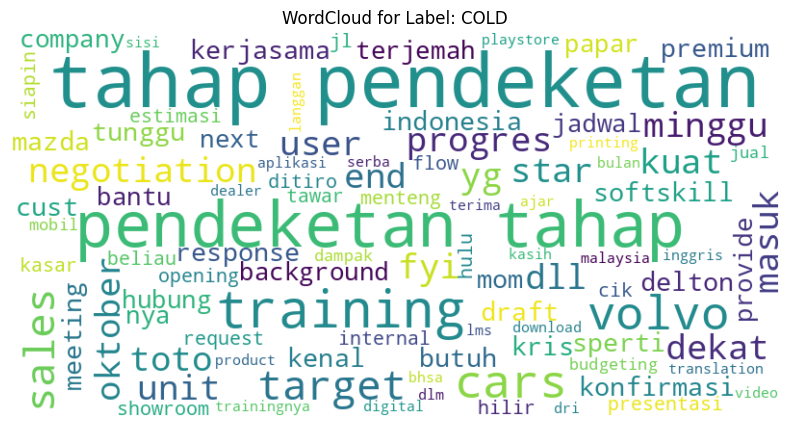

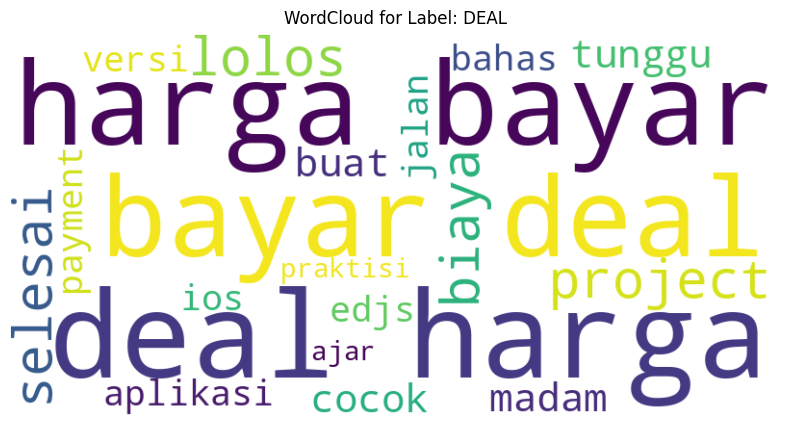

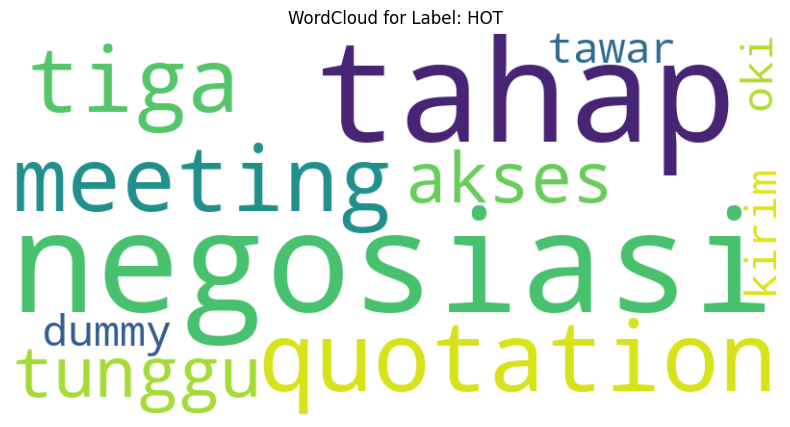

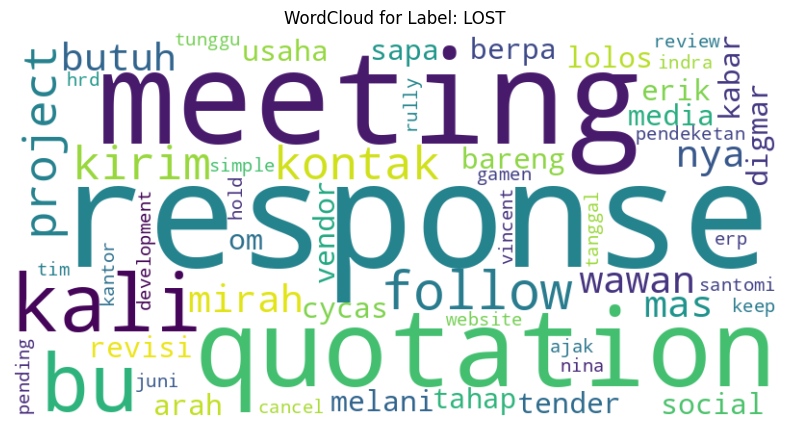

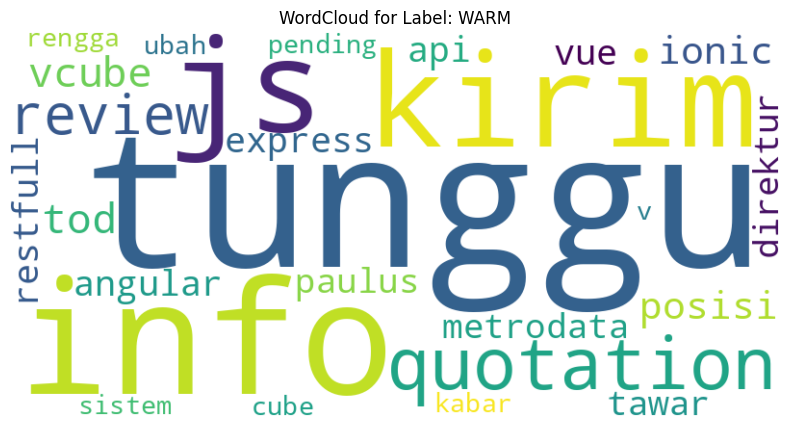

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Kelompokkan data berdasarkan kolom 'Label'
grouped = df.groupby('Label')

# Loop melalui setiap label dan tampilkan WordCloud
for label, group in grouped:
    text = ' '.join(group['Note'])  # Gabungkan semua teks dari kolom 'Note' untuk label tersebut

    # Buat WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Label: {label}")
    plt.show()


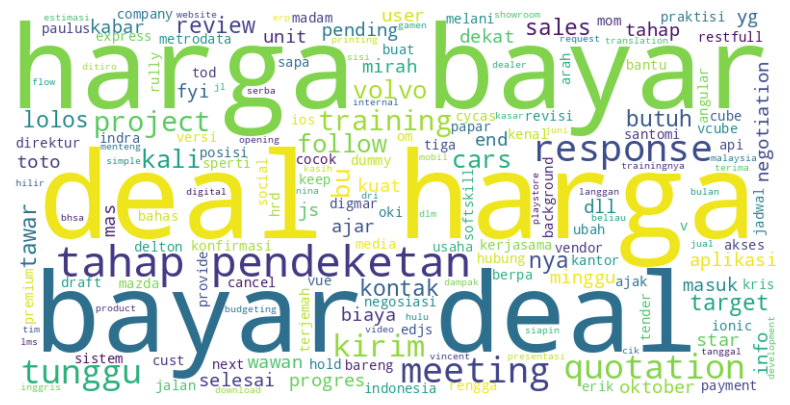

In [ ]:
# WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(df['Note'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['Note']).toarray()

####

## Modeling

### Split data

In [ ]:
import numpy as np
X = np.hstack((df[['Activity Score']].values, tfidf_matrix))
y = df['Label'].replace({'LOST': 0, 'COLD': 1, 'WARM': 2, 'HOT': 3, 'DEAL': 4}).values

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 2, 2, 2, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 4, 4, 0, 3,
       1, 0, 4, 1, 1, 1, 4, 1, 1, 4, 4, 0, 4, 4, 1, 0, 1, 0, 4, 3, 0, 3,
       0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

In [ ]:
from sklearn.linear_model import RidgeClassifierCV

clf = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8235294117647058

### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[7 0 0 0]
 [1 3 0 0]
 [2 0 0 0]
 [0 0 0 4]]
              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      0.75      0.86         4
           2       0.00      0.00      0.00         2
           4       1.00      1.00      1.00         4

    accuracy                           0.82        17
   macro avg       0.68      0.69      0.67        17
weighted avg       0.76      0.82      0.78        17



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=100)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[7 0 0 0]
 [1 3 0 0]
 [2 0 0 0]
 [0 0 0 4]]
              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      0.75      0.86         4
           2       0.00      0.00      0.00         2
           4       1.00      1.00      1.00         4

    accuracy                           0.82        17
   macro avg       0.68      0.69      0.67        17
weighted avg       0.76      0.82      0.78        17



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators=100)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[7 0 0 0]
 [0 3 1 0]
 [2 0 0 0]
 [0 0 0 4]]
              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       1.00      0.75      0.86         4
           2       0.00      0.00      0.00         2
           4       1.00      1.00      1.00         4

    accuracy                           0.82        17
   macro avg       0.69      0.69      0.68        17
weighted avg       0.79      0.82      0.80        17



In [ ]:
import joblib
joblib.dump(model, 'adaboost_model.pkl')

['adaboost_model.pkl']

### Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 32)                  │           5,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,053 (23.64 KB)

 Trainable params: 6,053 (23.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.1562 - loss: 1.6519 - val_accuracy: 0.1765 - val_loss: 1.6558
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1875 - loss: 1.6349 - val_accuracy: 0.1765 - val_loss: 1.6445
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1875 - loss: 1.6206 - val_accuracy: 0.1765 - val_loss: 1.6336
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2083 - loss: 1.6049 - val_accuracy: 0.1765 - val_loss: 1.6227
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2083 - loss: 1.5936 - val_accuracy: 0.1765 - val_loss: 1.6119
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2500 - loss: 1.5834 - val_accuracy: 0.1765 - val_loss: 1.6016
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2604 - loss: 1.5676 - val_accuracy: 0.2353 - val_loss: 1.5912
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2917 - loss: 1.5591 - val_accuracy: 0.5294 - val_loss

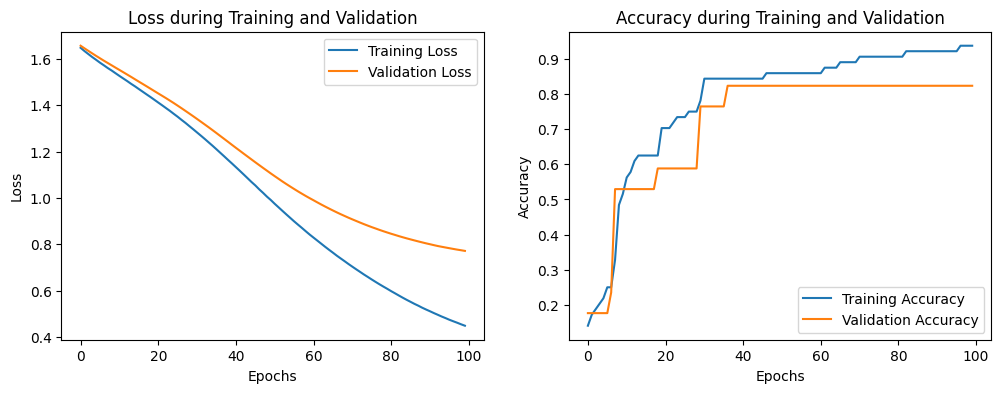

In [ ]:
# Loss plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


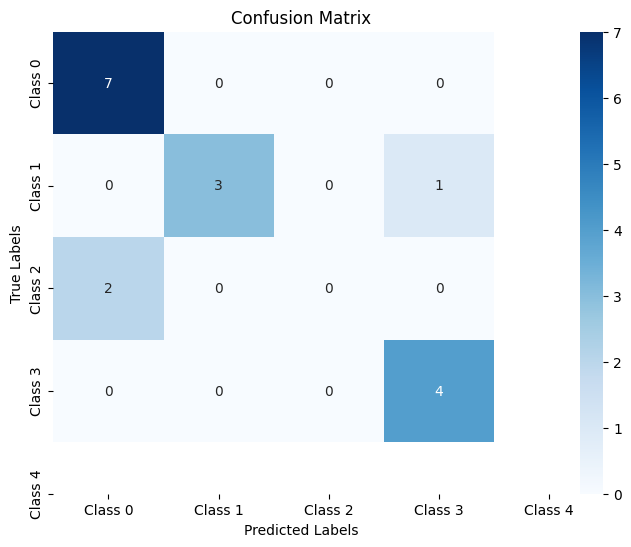

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('modelANN.h5')

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(X_train.shape[1:])))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))  # Output layer untuk 5 kelas

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,517 (17.64 KB)

 Trainable params: 4,517 (17.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 596ms/step - accuracy: 0.1458 - loss: 1.6087 - val_accuracy: 0.4118 - val_loss: 1.6065
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.3438 - loss: 1.6060 - val_accuracy: 0.4118 - val_loss: 1.6034
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3542 - loss: 1.6028 - val_accuracy: 0.4118 - val_loss: 1.6001
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3229 - loss: 1.6006 - val_accuracy: 0.4118 - val_loss: 1.5964
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3333 - loss: 1.5980 - val_accuracy: 0.4118 - val_loss: 1.5924
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2812 - loss: 1.5959 - val_accuracy: 0.4118 - val_loss: 1.5885
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3438 - loss: 1.5906 - val_accuracy: 0.4118 - val_loss: 1.5841
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3438 - loss: 1.5871 - val_accuracy: 0.4118 - val_loss

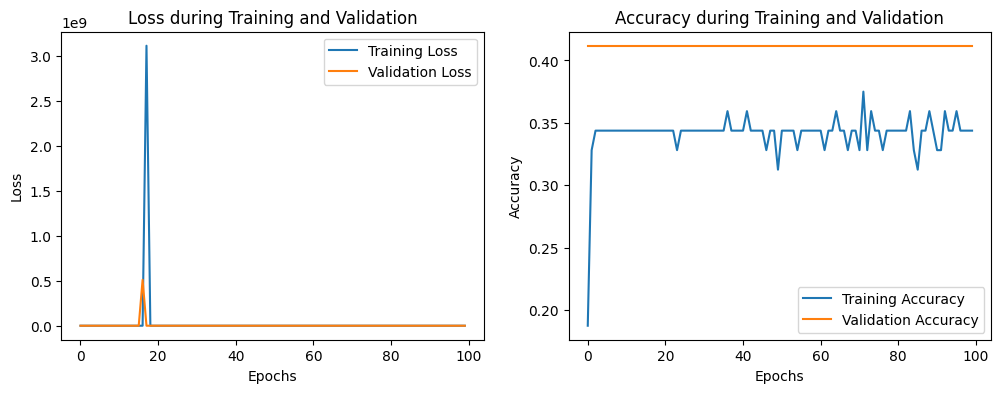

In [ ]:
# Loss plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


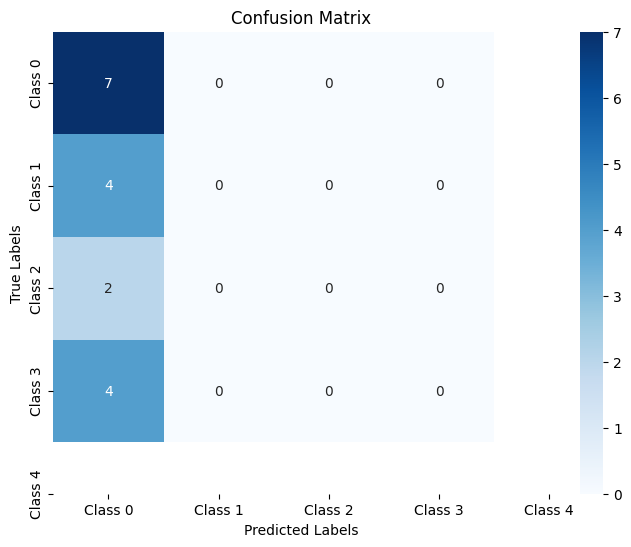

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save('modelLSTM.h5')

In [ ]:
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(GRU(50, activation='relu', input_shape=(X_train.shape[1:])))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))  # Output layer untuk 5 kelas

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,205 (32.05 KB)

 Trainable params: 8,205 (32.05 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.3333 - loss: 1.6090 - val_accuracy: 0.2353 - val_loss: 1.6062
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3646 - loss: 1.6056 - val_accuracy: 0.2353 - val_loss: 1.6032
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3854 - loss: 1.6025 - val_accuracy: 0.2353 - val_loss: 1.6002
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3333 - loss: 1.6002 - val_accuracy: 0.2353 - val_loss: 1.5968
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3438 - loss: 1.5959 - val_accuracy: 0.2353 - val_loss: 1.5930
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2812 - loss: 1.5921 - val_accuracy: 0.2353 - val_loss: 1.5889
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2917 - loss: 1.5874 - val_accuracy: 0.2353 - val_loss: 1.5847
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4062 - loss: 1.5804 - val_accuracy: 0.2353 - val_loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


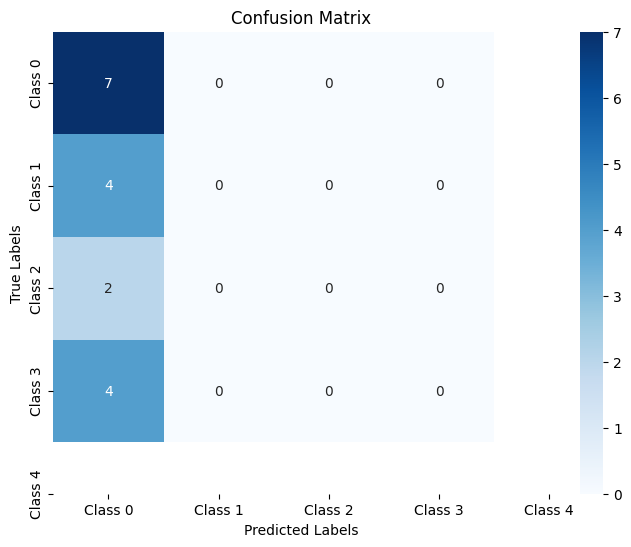

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save('modelGRU.h5')

## Load model

### Adaboost

In [ ]:
loaded_model = joblib.load('adaboost_model.pkl')

In [ ]:
predictions = loaded_model.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluasi model
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, predictions))

Accuracy: 0.8235294117647058


In [ ]:
hasil = pd.DataFrame({'y_test':y_test, 'predict':predictions})
hasil.replace({0:'LOST', 1:'COLD', 2:'WARM', 3:'HOT', 4:'DEAL'})

,y_test,predict
0,LOST,LOST
1,DEAL,DEAL
2,LOST,LOST
3,COLD,WARM
4,WARM,LOST
5,LOST,LOST
6,DEAL,DEAL
7,LOST,LOST
8,DEAL,DEAL
9,DEAL,DEAL


### NN

In [ ]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('modelANN.h5')

In [ ]:
predictions = loaded_model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8235294117647058
